Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [15]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [16]:
## If you are using the data by mounting the google drive, use the following :
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# #unzip the dataset
#!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [17]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = "/content/gdrive/MyDrive/skin_cancer"
data_dir_train = pathlib.Path(root_path + '/Train')

data_dir_test = pathlib.Path(root_path + '/Test')


In [18]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of images for training: ",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of images for testing: ",image_count_test)

Number of images for training:  2239
Number of images for testing:  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [19]:
batch_size = 32
img_height = 180
img_width = 180


Use 80% of the images for training, and 20% for validation.

In [20]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis',\
                 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'],
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='lanczos3', # for high-quality results for enlarging images, methods like "lanczos3" or "mitchellcubic" are preferable.
    verbose=True
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [21]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis',\
                 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'],
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='lanczos3', # for high-quality results for enlarging images, methods like "lanczos3" or "mitchellcubic" are preferable.
    verbose=True
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(180, 180),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [22]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

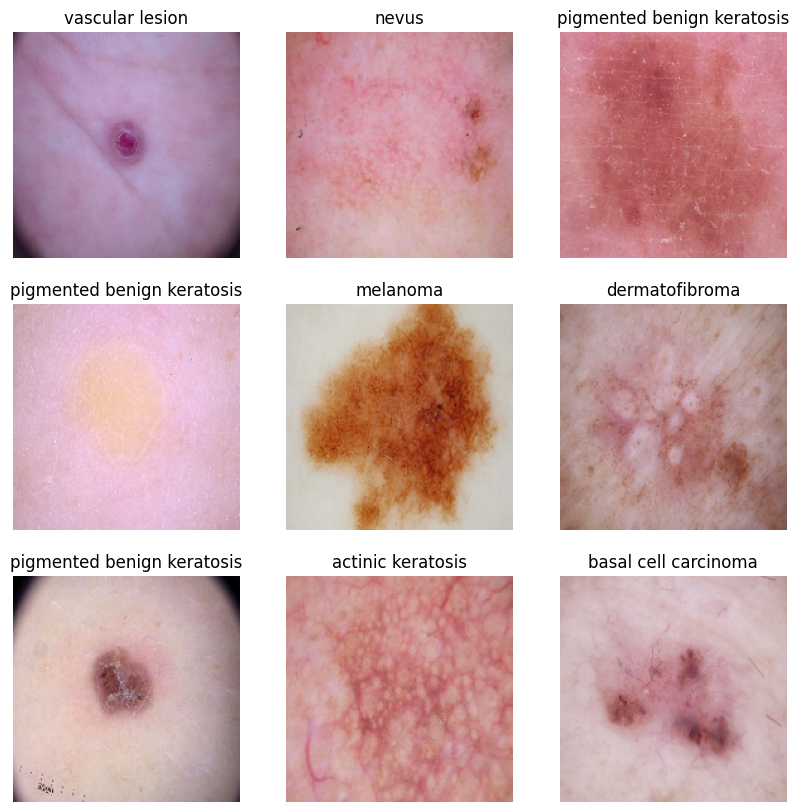

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())]) # label is a tensor [0. 1. 0. 0. 0. 0. 0. 0. 0.] converting to numpy and taking maxvalue index.
        plt.axis("off")
#This method converts the NumPy array’s data type to uint8 (unsigned 8-bit integer). This is a common data type for image pixel values, where each pixel is represented by an integer between 0 and 255.


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


In [ ]:
## labels for each batch total 56 batches- and 9 labels for each batch
import matplotlib.pyplot as plt

## your code goes here, you can use training or validation data to visualize
class_counts = {class_name: 0 for class_name in class_names}

# Iterate through the dataset and count occurrences
count = 0
for images, labels in train_ds:
    count = count + 1
    print(tf.argmax(labels.numpy().astype(int)))
print("Total number of batches", count)


tf.Tensor([13  5 10  0  1  7  3  8  0], shape=(9,), dtype=int64)
tf.Tensor([16 19  3  5  2  8 13  1  0], shape=(9,), dtype=int64)
tf.Tensor([12  1  0  8  2  0  3  6  5], shape=(9,), dtype=int64)
tf.Tensor([ 4  1  5  3  2 13 29  6  0], shape=(9,), dtype=int64)
tf.Tensor([29  7  1  5  2 10 14  3  0], shape=(9,), dtype=int64)
tf.Tensor([ 5  0 17  3 11  9  2 27 31], shape=(9,), dtype=int64)
tf.Tensor([ 5  1  0  0 23  3  8 16 29], shape=(9,), dtype=int64)
tf.Tensor([ 3  4  0  1  0  7 14  8  2], shape=(9,), dtype=int64)
tf.Tensor([ 0  3 28  1  7  0 25  6  5], shape=(9,), dtype=int64)
tf.Tensor([ 3  1 28  7  0  4 19  2 18], shape=(9,), dtype=int64)
tf.Tensor([17  2 13  1  3  5 11  0  0], shape=(9,), dtype=int64)
tf.Tensor([11  0 15  5  1  3  7  2  6], shape=(9,), dtype=int64)
tf.Tensor([ 0 17  8  9 14  3  2  1  0], shape=(9,), dtype=int64)
tf.Tensor([20 10  0  2  4  5  0 22  0], shape=(9,), dtype=int64)
tf.Tensor([ 6  0 20  2  4  3  0  5 10], shape=(9,), dtype=int64)
tf.Tensor([ 0  2  0  5 13

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
print("Tensforflow version: ", tf.__version__)

Tensforflow version:  2.17.0


In [ ]:
### Your code goes here
from tensorflow.keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, Rescaling
#the experimental part has been deprecated in favor of stable APIs.
#tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3))
model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(9, activation='sigmoid'))
## Number of classes is 9
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 176, 176, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 176, 176, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 88, 88, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 86, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 84, 84, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 84, 84, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 38, 38, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 36, 36, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 36, 36, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,635,561 (25.31 MB)

 Trainable params: 6,634,601 (25.31 MB)

 Non-trainable params: 960 (3.75 KB)

### Compile the model
Choose an appropirate optimiser and loss function for model training

- Categorical Crossentropy:
Description: Computes the cross-entropy loss for multi-class classification where each example belongs to one of many classes.
Usage: Use this for multi-class classification problems where the labels are one-hot encoded (e.g., classifying images into one of several categories).
-  Categorical Focal Crossentropy:
Description: Combines categorical cross-entropy with focal loss, focusing more on hard-to-classify examples and addressing class imbalance.
Usage: Use this for multi-class classification problems with class imbalance.

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 176, 176, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 176, 176, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 88, 88, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 86, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 84, 84, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 84, 84, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 38, 38, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 36, 36, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 36, 36, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,635,561 (25.31 MB)

 Trainable params: 6,634,601 (25.31 MB)

 Non-trainable params: 960 (3.75 KB)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.2420 - loss: 5.7102 - val_accuracy: 0.2058 - val_loss: 3.4211
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.3685 - loss: 2.7870 - val_accuracy: 0.2058 - val_loss: 2.6976
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.3638 - loss: 2.0411 - val_accuracy: 0.1812 - val_loss: 2.3007
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.4124 - loss: 1.6548 - val_accuracy: 0.2774 - val_loss: 2.1132
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.4662 - loss: 1.5129 - val_accuracy: 0.1387 - val_loss: 2.7444
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.4788 - loss: 1.4551 - val_accuracy: 0.2394 - val_loss: 2.4376
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.5177 - loss: 1.3393 - val_accuracy: 0.2886 - val_loss: 2.6059
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.4929 - loss: 1.3817 - val_accuracy: 0.1320 -

### Visualizing training results

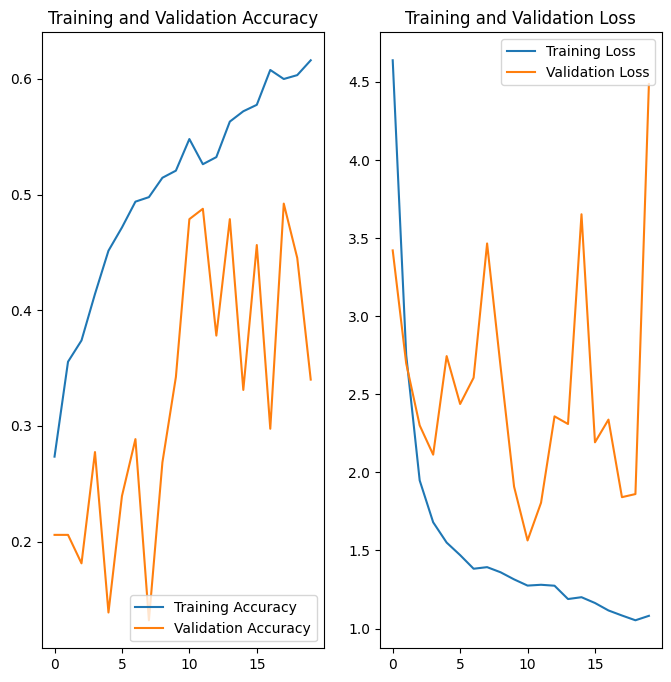

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Model is getting overfitted, model not getting actual patterns of validation set.

### Write your findings here

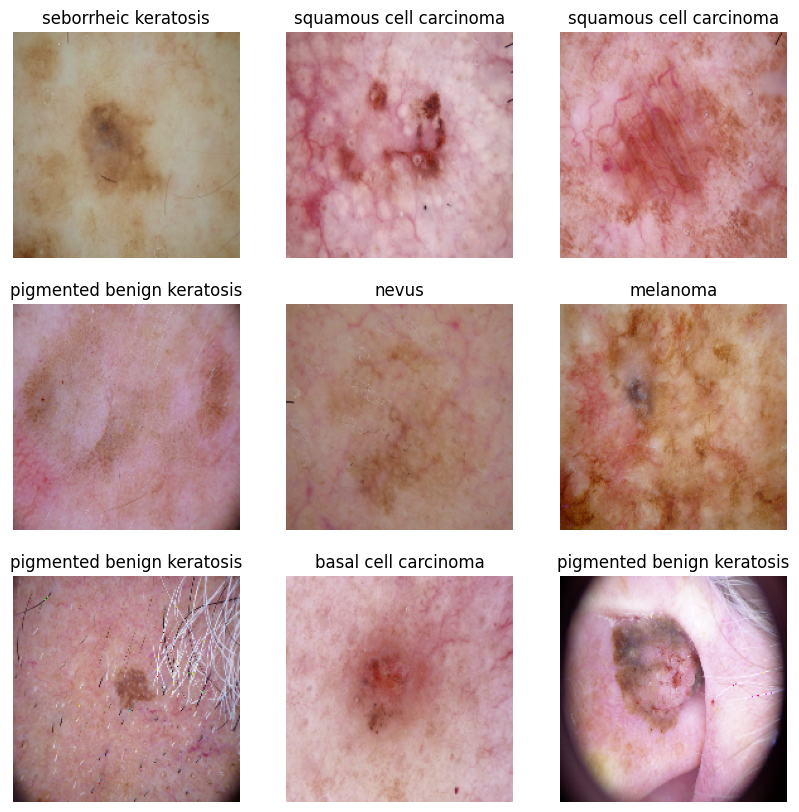

In [ ]:
# images before augmentaion strategy
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())]) # label is a tensor [0. 1. 0. 0. 0. 0. 0. 0. 0.] converting to numpy and taking maxvalue index.
        plt.axis("off")

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# ### Your code goes here
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


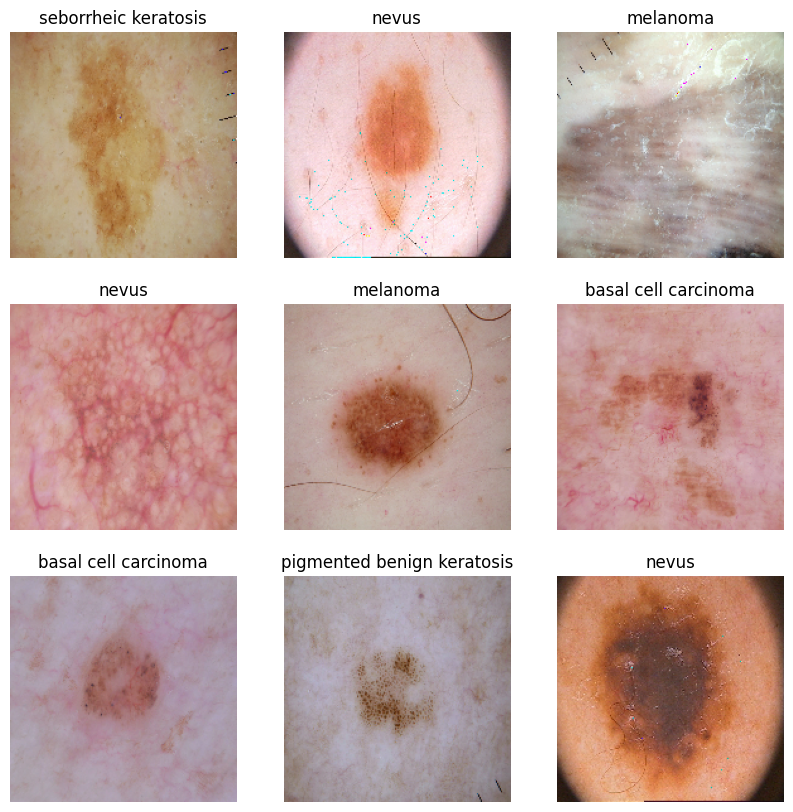

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Plot some augmented images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())]) # label is a tensor [0. 1. 0. 0. 0. 0. 0. 0. 0.] converting to numpy and taking maxvalue index.
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here
from tensorflow.keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, Rescaling
from tensorflow.keras import regularizers
#the experimental part has been deprecated in favor of stable APIs.
#tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3))
model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))


model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))



model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))



model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))



model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(9, activation='sigmoid'))
## Number of classes is 9
model.summary()



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_75 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 178, 178, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 87, 87, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 41, 41, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_78 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 18, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_79 (Conv2D)                   │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_64               │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,579,369 (6.02 MB)

 Trainable params: 1,578,377 (6.02 MB)

 Non-trainable params: 992 (3.88 KB)

### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.2919 - loss: 4.0760 - val_accuracy: 0.1588 - val_loss: 2.9677
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4144 - loss: 1.8100 - val_accuracy: 0.1499 - val_loss: 5.6525
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4399 - loss: 1.6263 - val_accuracy: 0.2013 - val_loss: 4.6150
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5041 - loss: 1.4261 - val_accuracy: 0.1790 - val_loss: 3.8490
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5172 - loss: 1.3261 - val_accuracy: 0.2013 - val_loss: 5.1555
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5849 - loss: 1.2097 - val_accuracy: 0.1879 - val_loss: 3.3842
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5464 - loss: 1.2906 - val_accuracy: 0.2103 - val_loss: 4.2304
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5783 - loss: 1.1830 - val_accuracy: 0.2774 - 

### Visualizing the results

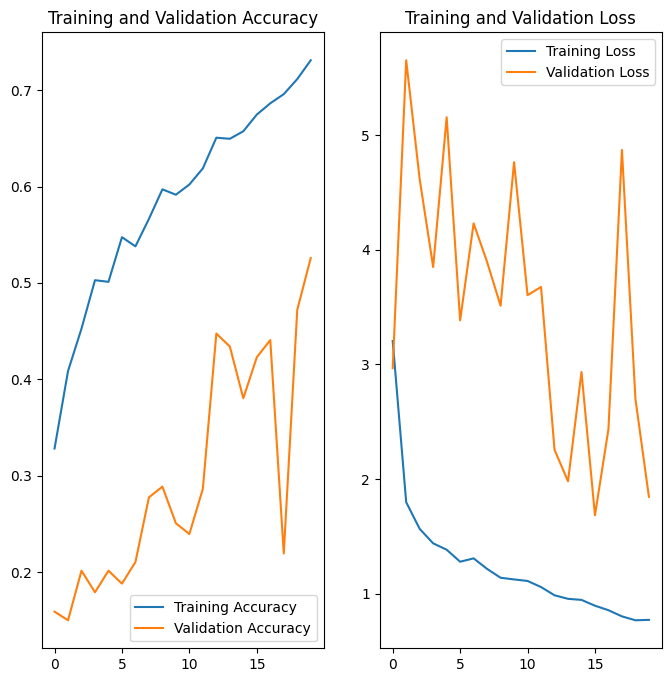

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Now model is still overfitting but difference between training and validation sets reduced compared to first model

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

<BarContainer object of 9 artists>

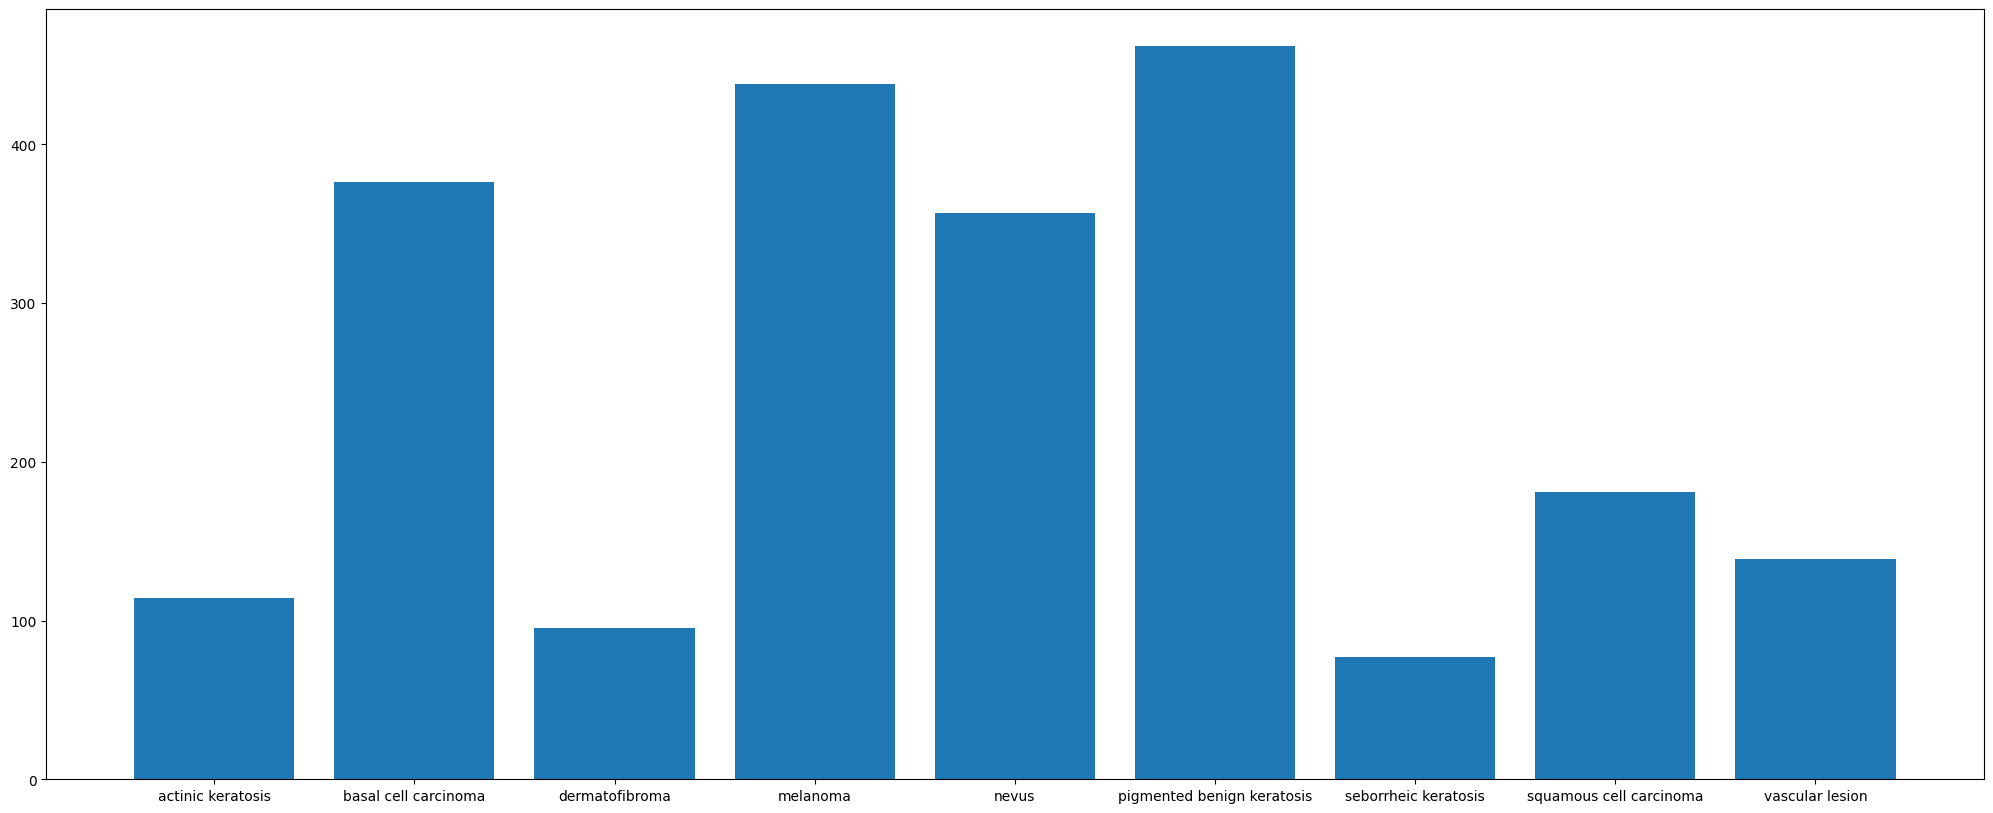

In [ ]:
# Visualize class imbalance through chart
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
- seborrheic keratosis, dermatofibroma, actinic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented bengin keratosis,,melanoma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
path_to_training_dataset= data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E700469C1C0>: 100%|██████████| 500/500 [00:06<00:00, 75.36 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E71BDAF3E20>: 100%|██████████| 500/500 [00:05<00:00, 98.98 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin_cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E7004638250>: 100%|██████████| 500/500 [00:05<00:00, 92.95 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin_cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E70604A9ED0>: 100%|██████████| 500/500 [00:17<00:00, 28.51 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7E70042AB4F0>: 100%|██████████| 500/500 [00:18<00:00, 27.44 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E704EEAD540>: 100%|██████████| 500/500 [00:05<00:00, 93.63 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E6FB028C4C0>: 100%|██████████| 500/500 [00:09<00:00, 51.17 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6FB861B6D0>: 100%|██████████| 500/500 [00:05<00:00, 94.69 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin_cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E704EEADD80>: 100%|██████████| 500/500 [00:05<00:00, 88.28 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/skin_cancer/Train/nevus/output/nevus_original_ISIC_0026457.jpg_c78c3ad8-bea6-4bc9-b913-7fac1a69e158.jpg',
 '/content/gdrive/MyDrive/skin_cancer/Train/nevus/output/nevus_original_ISIC_0000357.jpg_b7101e16-846b-4b02-aed8-2c1191bc0931.jpg',
 '/content/gdrive/MyDrive/skin_cancer/Train/nevus/output/nevus_original_ISIC_0000265.jpg_83cc8a16-7d31-497f-9931-b4c53782ebaf.jpg',
 '/content/gdrive/MyDrive/skin_cancer/Train/nevus/output/nevus_original_ISIC_0000500.jpg_d0946b21-ae9e-48fe-8505-d2eb42cc400c.jpg',
 '/content/gdrive/MyDrive/skin_cancer/Train/nevus/output/nevus_original_ISIC_0000367.jpg_d5a8df9d-d6a9-4466-84e7-ed354ed1f1e2.jpg',
 '/content/gdrive/MyDrive/skin_cancer/Train/nevus/output/nevus_original_ISIC_0000360.jpg_0dcfea8b-62fc-49be-bd04-72b4288c9f51.jpg',
 '/content/gdrive/MyDrive/skin_cancer/Train/nevus/output/nevus_original_ISIC_0000315.jpg_1cfcc9ec-9ba8-4840-b76f-a174bce24d42.jpg',
 '/content/gdrive/MyDrive/skin_cancer/Train/nevus/output/nevus_original_ISIC

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [ ]:
new_df['Label'].value_counts()

Label
nevus                         500
actinic keratosis             500
basal cell carcinoma          500
pigmented benign keratosis    500
vascular lesion               500
squamous cell carcinoma       500
melanoma                      500
dermatofibroma                500
seborrheic keratosis          500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train= data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
### Your code goes here
from tensorflow.keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, Rescaling
from tensorflow.keras import regularizers

model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(9, activation='sigmoid'))
## Number of classes is 9
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_14 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_128 (Conv2D)                  │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_129 (Conv2D)                  │ (None, 176, 176, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_103              │ (None, 176, 176, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_72 (MaxPooling2D)      │ (None, 88, 88, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 88, 88, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_130 (Conv2D)                  │ (None, 86, 86, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_131 (Conv2D)                  │ (None, 84, 84, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_104              │ (None, 84, 84, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_73 (MaxPooling2D)      │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_132 (Conv2D)                  │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_133 (Conv2D)                  │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_105              │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_74 (MaxPooling2D)      │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_134 (Conv2D)                  │ (None, 17, 17, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_135 (Conv2D)                  │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_106              │ (None, 15, 15, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,316,953 (5.02 MB)

 Trainable params: 1,315,961 (5.02 MB)

 Non-trainable params: 992 (3.88 KB)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 116ms/step - accuracy: 0.2181 - loss: 2.4303 - val_accuracy: 0.0965 - val_loss: 2.9056
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.3538 - loss: 1.7070 - val_accuracy: 0.1366 - val_loss: 2.6539
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.4135 - loss: 1.5744 - val_accuracy: 0.1878 - val_loss: 3.7391
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.4234 - loss: 1.5013 - val_accuracy: 0.3163 - val_loss: 2.2166
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.4647 - loss: 1.3932 - val_accuracy: 0.4113 - val_loss: 1.8409
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5134 - loss: 1.2891 - val_accuracy: 0.4336 - val_loss: 1.4806
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.5153 - loss: 1.2983 - val_accuracy: 0.4655 - val_loss: 1.5232
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5494 - loss: 1.1771 -

#### **Todo:**  Visualize the model results

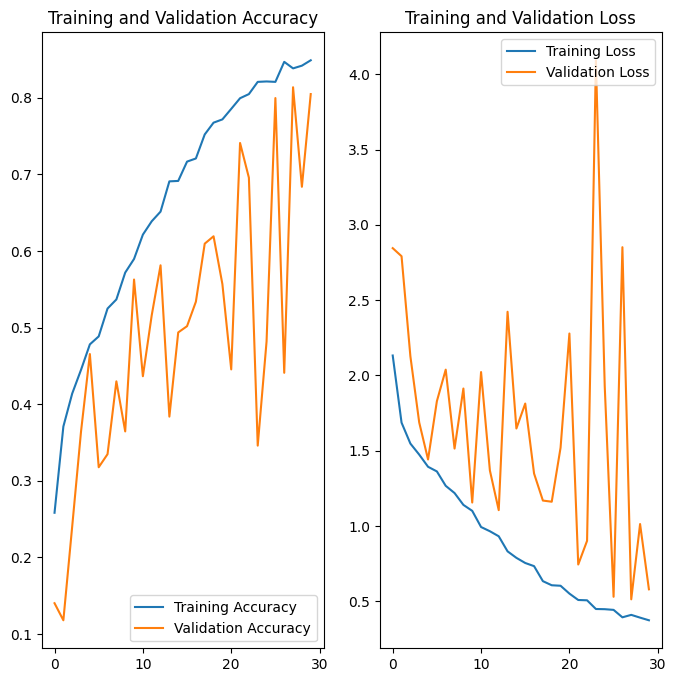

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
- Yes model got rid of overfitting. Training and validation accuracies are 91 and 87 respectively. But model seems to be unstable as validation accuracy going up and down for each epoch.


<BarContainer object of 9 artists>

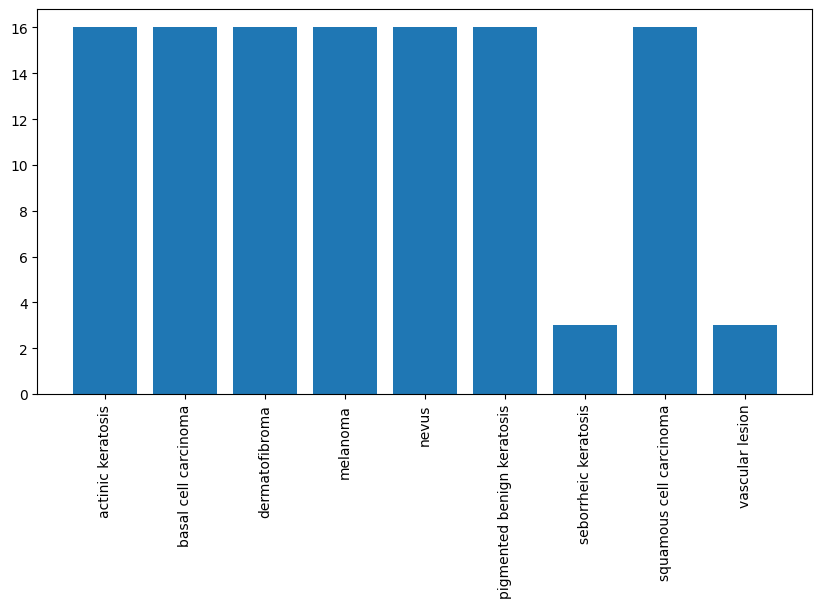

In [ ]:
# Visualize class distribution in test set
count=[]
for i in class_names:
    count.append(len(list(data_dir_test.glob(i+'/*.jpg'))))
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
plt.bar(class_names,count)

In [ ]:
# Make predictions
predictions = model.predict(test_ds)
print(predictions)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
[[9.85358596e-01 6.61148369e-01 1.81946322e-01 ... 9.20337261e-05
  9.79480028e-01 2.83372980e-02]
 [2.80066460e-01 9.98133481e-01 3.09772015e-01 ... 3.76460994e-05
  9.99220133e-01 3.94109666e-05]
 [3.24466556e-01 1.98088527e-01 1.42608844e-02 ... 6.69037341e-04
  9.99616742e-01 2.78857100e-04]
 ...
 [1.04552731e-02 4.64069098e-02 1.32013625e-03 ... 3.47131107e-04
  1.26640813e-03 3.65351420e-03]
 [5.09341806e-02 1.45127997e-01 9.55649912e-01 ... 2.79611442e-02
  3.77105772e-02 1.11467885e-02]
 [6.17108867e-03 5.86488796e-03 8.04767758e-02 ... 4.58399858e-03
  1.30043467e-04 4.50770184e-03]]
[0 7 7 6 1 1 4 1 2 0 7 1 5 4 2 7 3 8 1 3 2 4 8 4 1 5 3 3 4 3 3 4 5 8 5 4 4
 0 3 5 2 4 3 4 1 1 4 5 5 3 4 0 7 3 3 4 3 3 4 3 1 1 7 1 3 3 4 2 4 1 3 3 0 0
 4 2 4 4 2 1 4 3 4 2 4 3 4 7 4 4 4 2 5 5 5 4 4 5 1 1 3 3 5 3 5 4 4 5 4 4 8
 4 7 1 8 4 2 4]


In [ ]:
predicted_classes # total 118 images predicted labels

array([0, 7, 7, 6, 1, 1, 4, 1, 2, 0, 7, 1, 5, 4, 2, 7, 3, 8, 1, 3, 2, 4,
       8, 4, 1, 5, 3, 3, 4, 3, 3, 4, 5, 8, 5, 4, 4, 0, 3, 5, 2, 4, 3, 4,
       1, 1, 4, 5, 5, 3, 4, 0, 7, 3, 3, 4, 3, 3, 4, 3, 1, 1, 7, 1, 3, 3,
       4, 2, 4, 1, 3, 3, 0, 0, 4, 2, 4, 4, 2, 1, 4, 3, 4, 2, 4, 3, 4, 7,
       4, 4, 4, 2, 5, 5, 5, 4, 4, 5, 1, 1, 3, 3, 5, 3, 5, 4, 4, 5, 4, 4,
       8, 4, 7, 1, 8, 4, 2, 4])

In [ ]:
actual_labels = []
for images, labels in test_ds:
  labels.numpy().flatten()
  actual_labels.append(labels.numpy())

print(actual_labels)


[7 5 7 1 4 1 0 1 6 7 5 4 2 8 3 5 0 2 0 7 3 2 0 3 2 1 5 5 7 3 0 5]
[4 3 2 3 3 2 2 7 5 5 1 2 3 3 0 5 7 2 3 4 7 0 2 1 4 7 1 0 7 4 7 8]
[5 5 0 8 0 0 1 1 1 0 1 4 2 3 0 4 2 5 4 0 1 7 3 1 7 5 1 7 6 4 7 1]
[5 4 3 3 4 0 2 1 2 4 4 5 7 3 4 3 6 5 2 4 0 2]
[array([7, 5, 7, 1, 4, 1, 0, 1, 6, 7, 5, 4, 2, 8, 3, 5, 0, 2, 0, 7, 3, 2,
       0, 3, 2, 1, 5, 5, 7, 3, 0, 5], dtype=int32), array([4, 3, 2, 3, 3, 2, 2, 7, 5, 5, 1, 2, 3, 3, 0, 5, 7, 2, 3, 4, 7, 0,
       2, 1, 4, 7, 1, 0, 7, 4, 7, 8], dtype=int32), array([5, 5, 0, 8, 0, 0, 1, 1, 1, 0, 1, 4, 2, 3, 0, 4, 2, 5, 4, 0, 1, 7,
       3, 1, 7, 5, 1, 7, 6, 4, 7, 1], dtype=int32), array([5, 4, 3, 3, 4, 0, 2, 1, 2, 4, 4, 5, 7, 3, 4, 3, 6, 5, 2, 4, 0, 2],
      dtype=int32)]


In [ ]:
actual_test_labels = np.concatenate(actual_labels)
actual_test_labels

array([7, 5, 7, 1, 4, 1, 0, 1, 6, 7, 5, 4, 2, 8, 3, 5, 0, 2, 0, 7, 3, 2,
       0, 3, 2, 1, 5, 5, 7, 3, 0, 5, 4, 3, 2, 3, 3, 2, 2, 7, 5, 5, 1, 2,
       3, 3, 0, 5, 7, 2, 3, 4, 7, 0, 2, 1, 4, 7, 1, 0, 7, 4, 7, 8, 5, 5,
       0, 8, 0, 0, 1, 1, 1, 0, 1, 4, 2, 3, 0, 4, 2, 5, 4, 0, 1, 7, 3, 1,
       7, 5, 1, 7, 6, 4, 7, 1, 5, 4, 3, 3, 4, 0, 2, 1, 2, 4, 4, 5, 7, 3,
       4, 3, 6, 5, 2, 4, 0, 2], dtype=int32)

## Model evaluation

In [ ]:
model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.5570 - loss: 3.2055


[3.527634859085083, 0.5254237055778503]

In [ ]:
# test accuracy is 55% and loss 3.20 model is predicting 55% of images correctly